# Testing new utility function for MPO

Data imports.

In [114]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [115]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [457]:
from itertools import combinations

num_annotations = 2
paths = [(0,), (1,)]
list(combinations(paths, num_annotations))[0]

((0,), (1,))

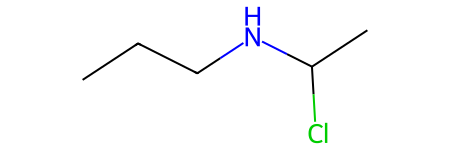

In [845]:
mol[0]

In [1560]:
# %%time
from rdkit.Chem.Descriptors import HeavyAtomCount
mol = designer.design(strategy='random')[0]
analog = designer.design(mol, strategy='grow')
analog[0]

IndexError: list index out of range

In [1512]:
mol = designer.design(strategy='random')[0]

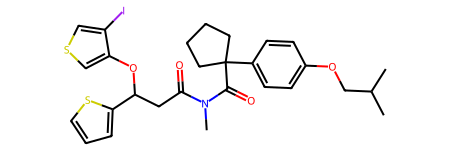

In [1550]:
designer.design(mol, strategy='grow')[0]

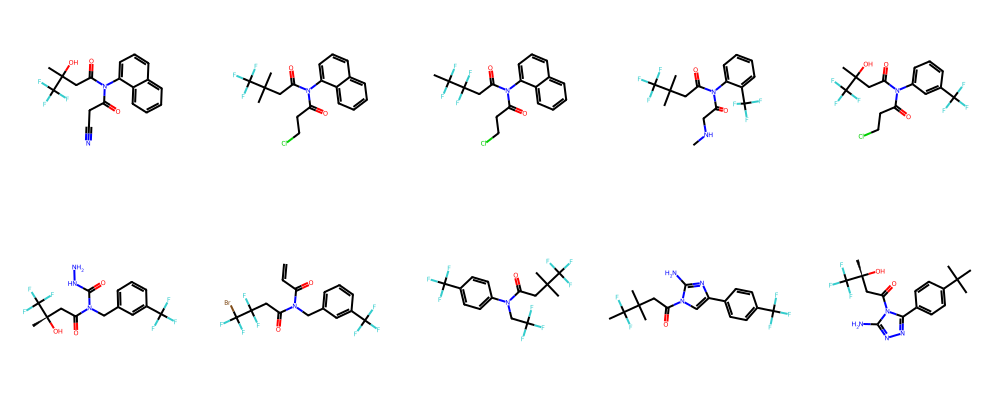

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in mol_drift[::10]],
    molsPerRow=5,
)